# Barcode search



In [26]:
from pathlib import Path
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
import torch.nn as nn
import torch
import lightning
from lightning.pytorch.loggers import TensorBoardLogger
import os

## Data

In [27]:
TRAIN_PATH = Path('data/Train').resolve()
TEST_PATH = Path('data/Test').resolve()
assert TRAIN_PATH.exists(), TEST_PATH.exists()
print(TEST_PATH)

/home/semyon/ML/OCR/task3/data/Test


In [28]:
df = pd.read_csv(TRAIN_PATH / 'markup.csv', encoding='utf-16', header=None)
df

,0,1,2,3,4,5,6,7,8,9,10
0,fc272e4092ccb147a31e66bc1d10fbfb.png,3601514743345,538,248,1590,225,1597,663,532,676,1010101111000110101100110111001011001101000110...
1,8cde8cb1b54bca37c9347baf74157d22.png,7000001062307,372,433,360,1289,124,1293,147,431,1010001101010011100011010100111000110101100110...
2,70a9be0887eae17eabd70c8e607f963f.png,2250001407126,408,230,1224,229,1224,688,414,683,1010010011011000101001110100111000110101100110...
3,a029e49dff95a15d2cd396d8f62220c8.png,10101427156,335,149,1005,155,1005,438,335,447,1010001101001100100011010011001000110100110010...
4,82ff01909b6d215170dfc26c7be43074.png,2400745402226,469,237,1388,260,1392,712,464,696,1010100011000110101001110010001010001101110010...
...,...,...,...,...,...,...,...,...,...,...,...
8194,c532771808e76e333ba9e959853886f3.png,4823077510083,86,54,622,53,622,202,87,202,1010110111001101101111010001101001000100100010...
8195,186338ad8f3ff17b6082c023f24563f0.png,4823077505386,109,44,664,55,668,206,107,192,1010110111001101101111010001101001000100100010...
8196,5bac8f6c9bd5e99f92eb396442974c4e.png,4823077505492,121,27,704,13,704,168,120,187,1010110111001101101111010001101001000100100010...
8197,6247db3e424148a859ebf2180f1dcb6f.png,2010000019696,158,81,165,518,62,521,55,82,1010001101001100101001110100111000110101001110...


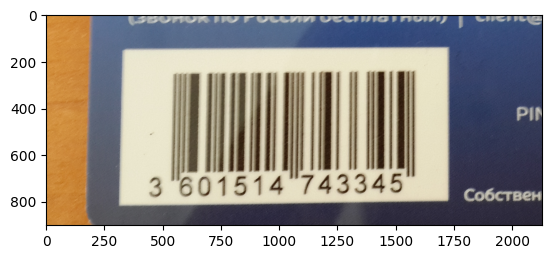

In [29]:
img = cv.cvtColor(cv.imread(f'{TRAIN_PATH}/Images/{df.iloc[0][0]}'), cv.COLOR_BGR2RGB)
plt.imshow(img)

In [30]:
class BarcodeDataset(Dataset):
    def __init__(self, df, path, resolution=(256,256)):
        self.df = df
        self.path = path
        self.resolution = resolution

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        src = cv.cvtColor(cv.imread(f'{self.path}/Images/{self.df.iloc[idx][0]}'), cv.COLOR_BGR2RGB)

        corners = np.array(df.iloc[idx][2:10], dtype=np.int32).reshape(-1, 2)
        trg = cv.fillConvexPoly(np.zeros(src.shape[:2]), corners, 1)

        src = transforms.ToTensor()(src)
        src = transforms.Resize(self.resolution)(src)
        trg = transforms.ToTensor()(trg)
        trg = transforms.Resize(self.resolution, interpolation=Image.NEAREST)(trg)
                
        return src, trg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train size: 6970
Val size: 1229


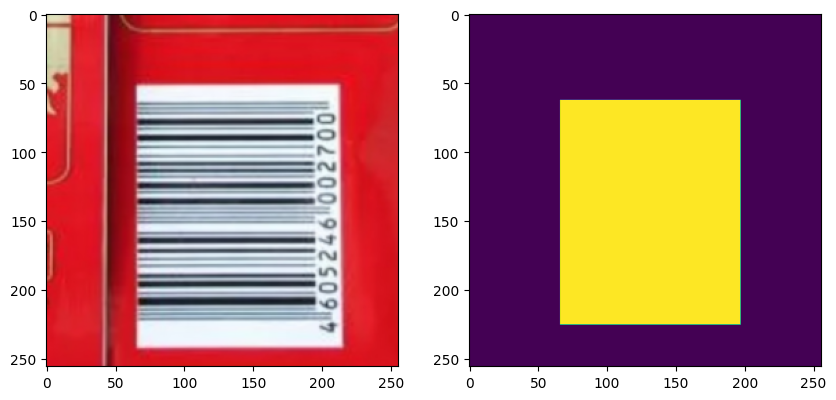

In [31]:
resolution = (256, 256)
train_dataset, val_dataset = random_split(BarcodeDataset(df, TRAIN_PATH, resolution), lengths=[0.85, 0.15])
batch_size = 6
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=4)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))

fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
img, mask = train_dataset[0]
axes[0].imshow(img.permute(1, 2, 0))
axes[1].imshow(mask.permute(1, 2, 0))

## Model

To find the barcode mask I used UNet wit ResNet blocks

In [32]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size=1),
                        nn.BatchNorm2d(out_channels))
        
    def forward(self, x):
        residual = self.downsample(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out += residual
        out = nn.ReLU()(out)
        return out

In [33]:
class ResUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.enc_conv1 = ResNetBlock(in_channels, 32)
        self.enc_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv2 = ResNetBlock(32, 64)
        self.enc_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv3 = ResNetBlock(64, 128)
        self.enc_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv4 = ResNetBlock(128, 256)
        self.enc_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bridge = ResNetBlock(256, 512)
        
        self.dec_upsample1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(512, 256, kernel_size=1)
        )
        self.dec_conv1 = ResNetBlock(512, 256)

        self.dec_upsample2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(256, 128, kernel_size=1)
        )
        self.dec_conv2 = ResNetBlock(256, 128)

        self.dec_upsample3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, kernel_size=1)
        )
        self.dec_conv3 = ResNetBlock(128, 64)

        self.dec_upsample4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, kernel_size=1)
        )
        self.dec_conv4 = ResNetBlock(64, 32)
        
        self.out = nn.Conv2d(32, out_channels, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.enc_conv1(x)
        enc2 = self.enc_conv2(self.enc_pool1(enc1))
        enc3 = self.enc_conv3(self.enc_pool2(enc2))
        enc4 = self.enc_conv4(self.enc_pool3(enc3))
        
        bridge = self.bridge(self.enc_pool4(enc4))
        
        out = self.dec_upsample1(bridge)
        out = torch.cat([out, enc4], dim=1)
        out = self.dec_conv1(out)
        
        out = self.dec_upsample2(out)
        out = torch.cat([out, enc3], dim=1)
        out = self.dec_conv2(out)

        out = self.dec_upsample3(out)
        out = torch.cat([out, enc2], dim=1)
        out = self.dec_conv3(out)
        
        out = self.dec_upsample4(out)
        out = torch.cat([out, enc1], dim=1)
        out = self.dec_conv4(out)
        
        out = self.out(out)
        return out

## Training

In [34]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        intersection = torch.sum(y_pred * y_true)
        union = torch.sum(y_pred) + torch.sum(y_true)
        dice_coefficient = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice_coefficient

In [35]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [36]:
class LitIdentifier(lightning.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = DiceLoss()
        
    def training_step(self, batch, batch_idx):
        inputs, targets = batch

        outputs = self.model(inputs)
        outputs = torch.sigmoid(outputs)
        loss = self.criterion(outputs, targets)
        
        self.log("train_loss", loss)
        
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch

        outputs = self.model(inputs)
        outputs = torch.sigmoid(outputs)
        loss = self.criterion(outputs, targets)
        
        self.log("val_loss", loss)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.model.parameters(), lr=1e-3)
        return optimizer

In [37]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = ResUNet(in_channels=3, out_channels=1).to(device)

lit_model = LitIdentifier(model)
logger = TensorBoardLogger("tb_logs", name="UNet")
trainer = lightning.Trainer(logger=logger, max_epochs=2)
trainer.fit(lit_model, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | model     | ResUNet  | 7.6 M 
1 | criterion | DiceLoss | 0     
---------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.386    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
%tensorboard --logdir tb_logs

In [ ]:
torch.save(model.state_dict(), "UNet.pt")

## Metrics

In [64]:
def get_corners(mask):
    mask = (mask.cpu().detach().numpy() > 0.5).astype(np.uint8)
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv.contourArea)
    x, y, w, h = cv.boundingRect(contour)
    return np.array([x, y + h, x, y, x + w, y, x + w, y + h])

In [68]:
answer = []

model.eval()
with torch.no_grad():
    for file in os.listdir(TEST_PATH / 'Images'):
        src = cv.cvtColor(cv.imread(f'{TEST_PATH}/Images/{file}'), cv.COLOR_BGR2RGB)
        shape = src.shape[:2]
        src = transforms.ToTensor()(src)
        img = transforms.Resize(resolution)(img)

        mask = model(img.to(device).unsqueeze(0))
        mask = transforms.Resize(shape, interpolation=Image.NEAREST)(mask)

        answer.append([file, get_corners(mask.squeeze())])

with open('answer.csv', mode='w', encoding='utf-16') as file:
    for i in range(len(answer)):
        file.write(answer[i][0] + ',-,' + ','.join([str(val) for val in answer[i][1]]) + ',-\n')

In [69]:
from course_intro_ocr_t3.evaluate import main

main()

Checking answer (/home/semyon/ML/OCR/task3/answer.csv) against markup(/home/semyon/ML/OCR/task3/markup.csv)
recognition_accuracy=0.0
detection_result=0.91
score=0.91
